## Please change the labeler name and path, then run all the cell

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## variable and path setup

labeler = 'Fairuuz ' # change here
path_to_robot_folder = '/content/drive/MyDrive/Robot Assembling' # change here

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

PATH FOR THE CLEAN CSV FILE AND WHERE WE GONNA SAVE THE LABELED FILE

In [4]:
right_hand_folder_path = f'{path_to_robot_folder}/sensors/clean/right'
left_hand_folder_path = f'{path_to_robot_folder}/sensors/clean/left'
save_left_path = f'{path_to_robot_folder}/sensors/labeled/left'
save_right_path = f'{path_to_robot_folder}/sensors/labeled/right'

## Code Functions for labeling - No need to modify, just run this

In [5]:
class LabelStatus:

  status_filename = f'{path_to_robot_folder}/python/label_status.csv'
  def __init__(self, labeler):
    self.labeler = labeler
    self.status_file = pd.read_csv(self.status_filename, index_col='index')

  def get_current_file(self):
    self.current_file = self.status_file.loc[((self.status_file['status'] == 'clean') | ((self.status_file['status'] == 'labeling') & (self.status_file['labeled_by'] == labeler))), ['video_file', 'sensor_left_file', 'sensor_right','status']].head(1)
    print("You are assigned to do labeling sensor files", self.current_file['sensor_left_file'].values[0], 'and',  self.current_file['sensor_right'].values[0])
    print('Please open video name {} for labeling. >> '.format(self.current_file['video_file'].values[0]))
    if self.current_file['status'].values[0] == 'labeling':
      left_hand_csv_path = os.path.join(save_left_path, self.current_file['sensor_left_file'].values[0])
      right_hand_csv_path = os.path.join(save_right_path, self.current_file['sensor_right'].values[0])
    else:
      left_hand_csv_path = os.path.join(left_hand_folder_path, self.current_file['sensor_left_file'].values[0])
      right_hand_csv_path = os.path.join(right_hand_folder_path, self.current_file['sensor_right'].values[0])
      self.update_label_status('labeling')
    save_left_csv_path = os.path.join(save_left_path, self.current_file['sensor_left_file'].values[0])
    save_right_csv_path = os.path.join(save_right_path, self.current_file['sensor_right'].values[0])
    return left_hand_csv_path, right_hand_csv_path, save_left_csv_path, save_right_csv_path


  def update_label_status(self, status):
    self.status_file = pd.read_csv(self.status_filename, index_col='index')
    self.status_file.loc[self.current_file.index, 'labeled_by'] = self.labeler
    self.status_file.loc[self.current_file.index, 'status'] = status
    self.status_file.to_csv(self.status_filename)
    print(f'Label status updated to {status}')



FUNCTION FOR LABELING THE DATA

In [6]:
def bydataToDealWith(df, start_time, end_time):
  """
  Find the nearest index in a dataframe that matches the start and end time.

  Args:
      df (pd.DataFrame): The dataframe to search.
      start_time (float): The start time to match.
      end_time (float): The end time to match.

  Returns:
      tuple: The index of the first row that matches the start time and the index of the last row that matches the end time.
  """
  start_index = df.index[df['video_time'] >= start_time][0]
  end_index = df.index[df['video_time'] <= end_time][-1]
  return start_index, end_index


In [7]:
import re

class LabelingTool:
  def __init__(self, left_hand_csv_path, right_hand_csv_path, save_left_csv_path, save_right_csv):
    self.leaf_hand_csv_path = left_hand_csv_path
    self.right_hand_csv_path = right_hand_csv_path
    self.save_left_csv_path = save_left_csv_path
    self.save_right_csv_path = save_right_csv
    self.data_lef = pd.read_csv(left_hand_csv_path)
    self.data_rig = pd.read_csv(right_hand_csv_path)

  def is_valid_label(self, label):
    pattern = r'[01]?[0-9],\d{2}:\d{2},\d{2}:\d{2},[LRA]'
    if re.match(pattern, label):
      return True
    else:
      return False

  def label_signal(self,byLorR, start_point, end_point, label):

      if label in range(18+1) :
          if byLorR=='L':
              start_index, end_index = bydataToDealWith(self.data_lef, start_point, end_point)
              self.data_lef.loc[start_index:end_index, 'label'] = label
          elif byLorR=='R':
              start_index, end_index = bydataToDealWith(self.data_rig, start_point, end_point)
              self.data_rig.loc[start_index:end_index, 'label'] = label
          elif byLorR == 'A':
              start_index, end_index = bydataToDealWith(self.data_lef, start_point, end_point)
              self.data_lef.loc[start_index:end_index, 'label'] = label
              start_indexr, end_indexr = bydataToDealWith(self.data_rig, start_point, end_point)
              self.data_rig.loc[start_indexr:end_indexr, 'label'] = label

          #plot_sig_by_point_label(byLorR, start_point, end_point) #可以註解掉這行加速
      else:
          print('Error label! (permit range 0~18) , or your label in not in the right format.')

  def save_label_file(self):
      self.data_lef.to_csv(save_left_csv_path, index=False)
      self.data_rig.to_csv(save_right_csv_path, index=False)

  def rewrite_label(self):
      self.data_lef.to_csv(self.leaf_hand_csv_path, index=False)
      self.data_rig.to_csv(self.right_hand_csv_path, index=False)

  def plot_sig_by_videoTime_label(self, LorR, start_time, end_time):
    if LorR=='L':
        data = pd.read_csv(left_hand_csv_path)
    elif LorR=='R':
        data = pd.read_csv(right_hand_csv_path)
    data_part = data[(data.video_time>=start_time)&(data.video_time<=end_time)]

    # data_part['video_time'] = pd.to_datetime(data_part['video_time'], format='%H:%M')

    # prompt: create list of color len = 17

    colors = ['gray','b','g','r','c','m','y','orange','fuchsia','lime','pink','brown','purple','olive','teal','navy','maroon','cyan','deeppink']
    labels=['0. Unclassified actions',
            '1. Spin screw by hand',
            '2. Spin screw by screwdriver',
            '3. Spin screw/nuts using hex key',
            '4. Spin screw/nuts using wrenches',
            '5. Remove screw by screwdriver',
            '6. Remove screw/nuts using hex key',
            '7. Remove screw/nuts using wrenches',
            '8. Remove screw by hand',
            '9. Rotate object',
            '10. Joining parts together',
            '11. Pick up parts',
            '12. Pick up screws/nuts/tools',
            '13. Put the screws (nuts) up',
            '14. Put the screws (nuts) sideways',
            '15. Turn manual page',
            '16. Wave hands',
            '17. Thinking/reading manual',
            '18. Holding robot part']
    for i in range(data_part.columns.get_loc('timestamp')+1, data_part.columns.get_loc('gyr_z')+1):
        fig = plt.figure(figsize=(25,5))
        ax1 = plt.subplot(1,1,1)
        plt.title(data_part.columns[i])
        ax1.locator_params(nbins=20, axis='x')

        for j in range(0,18+1):
            if j==0:
                ax1.plot(data_part.iloc[:,i], marker='.', color=colors[j], label=labels[j])
            else:
                ax1.plot(data_part[data_part['label']==j].iloc[:,i],
                     marker='.', color=colors[j], label=labels[j])

        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)
        # Move legend to the bottom and orient horizontally
        plt.subplots_adjust(bottom=0.25)

        # Set scond x-axis
        ax2 = ax1.twiny()

        prepare_ax2 = data_part.reset_index()
        prepare_ax2['index'] = prepare_ax2['index']
        ax2_values = prepare_ax2.groupby('video_time').first()['index']

        ### set same xlim(x_board), ax2 xlim not from 0 to len(data)
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks(ax2_values)
        ax2.set_xticklabels(ax2_values.index, rotation=45, ha='left')

        plt.show()

# Label
After you run the following code the system will automatically select the file you have to label.

You are suggested to find the video on this [drive](https://drive.google.com/drive/folders/1h25siq0ONaEc-uQunCSFeadsGum5dOo5) based on the file name showed.

After that you need to watch the video to find the action according to these label.

* '0. Unclassified actions'
* '1. Spin screw by hand',
* '2. Spin screw by screwdriver',
* '3. Spin screw/nuts using hex key',
* '4. Spin screw/nuts using wrenches',
* '5. Remove screw by screwdriver',
* '6. Remove screw/nuts using hex key',
* '7. Remove screw/nuts using wrenches',
* '8. Remove screw by hand',
* '9. Rotate object',
* '10. Joining parts together',
* '11. Pick up parts',
* '12. Pick up screws/nuts/tools',
* '13. Put the screws (nuts) up',
* '14. Put the screws (nuts) sideways',
* '15. Turn manual page',
* '16. Wave hands'

the thing you need to know is
- **Which hand is used on the action**: left hand (L), right hand (R) or both of the hand (A).
- **Start time** of the action in format of mm:ss ex. 00:23 , 12:01
- **End time** of the action in format of mm:ss ex. 00:23 , 12:01
- **Label number** of that action - please refer to list above. (no need to label action 0)


-----------------------------------
the label input should look like this: **16,00:01,00:04,A**
- 16 : action wave hands
- 00:01 : start time
- 00:04 : end time
- A : both hands

when you want to stop labeling please input:  **quit** , or **else your file will not be saved**

when the label of that data point/video is finished please input:  **done** ,or **else your file will not be saved**


In [8]:
### MAIN LABEL ## run this when you want to get a new data to label

label_status = LabelStatus(labeler)
left_hand_csv_path, right_hand_csv_path, save_left_csv_path, save_right_csv_path = label_status.get_current_file()

label_tool = LabelingTool(left_hand_csv_path, right_hand_csv_path, save_left_csv_path, save_right_csv_path)


You are assigned to do labeling sensor files 6011943_2024022603.csv and 6011969_2024022603.csv
Please open video name 2024-02-26 17-27-30.mkv for labeling. >> 
Label status updated to labeling


In [10]:
path = input('Please input your excel file path : ')
status = input('Are you done labeling the whole video?')
df = pd.read_excel(path)

for label_number, start_time, end_time, Lor in zip(df['Label Number'], df['Start_time'], df['End_time'], df['<L/R/A>']):
  label = ','.join([str(label_number), start_time, end_time, Lor])
  if not label_tool.is_valid_label(label):
    print('Invalid label : ' + label)
    continue
  label_tool.label_signal(Lor, start_time, end_time, label_number)
  print('Confirmed label : ' + str(label_number) + ', Start time : ' + start_time + ', End time : ' + end_time + ', By : ' + Lor)

if status == 'Yes':
  label_status.update_label_status('done')

label_tool.save_label_file()

Please input your excel file path : /content/example 20-25.xlsx
Are you done labeling the whole video?Yes
Confirmed label : 16, Start time : 00:00, End time : 00:03, By : L
Confirmed label : 16, Start time : 00:00, End time : 00:03, By : R
Confirmed label : 17, Start time : 00:03, End time : 00:07, By : L
Confirmed label : 17, Start time : 00:03, End time : 00:07, By : R
Confirmed label : 12, Start time : 00:07, End time : 00:48, By : L
Confirmed label : 11, Start time : 00:07, End time : 00:48, By : R
Confirmed label : 13, Start time : 00:48, End time : 00:58, By : L
Confirmed label : 13, Start time : 00:48, End time : 00:58, By : R
Confirmed label : 3, Start time : 00:58, End time : 01:11, By : L
Confirmed label : 18, Start time : 00:58, End time : 01:11, By : L
Confirmed label : 10, Start time : 01:11, End time : 01:18, By : R
Confirmed label : 12, Start time : 01:18, End time : 01:52, By : L
Confirmed label : 2, Start time : 01:18, End time : 01:26, By : R
Confirmed label : 11, Sta

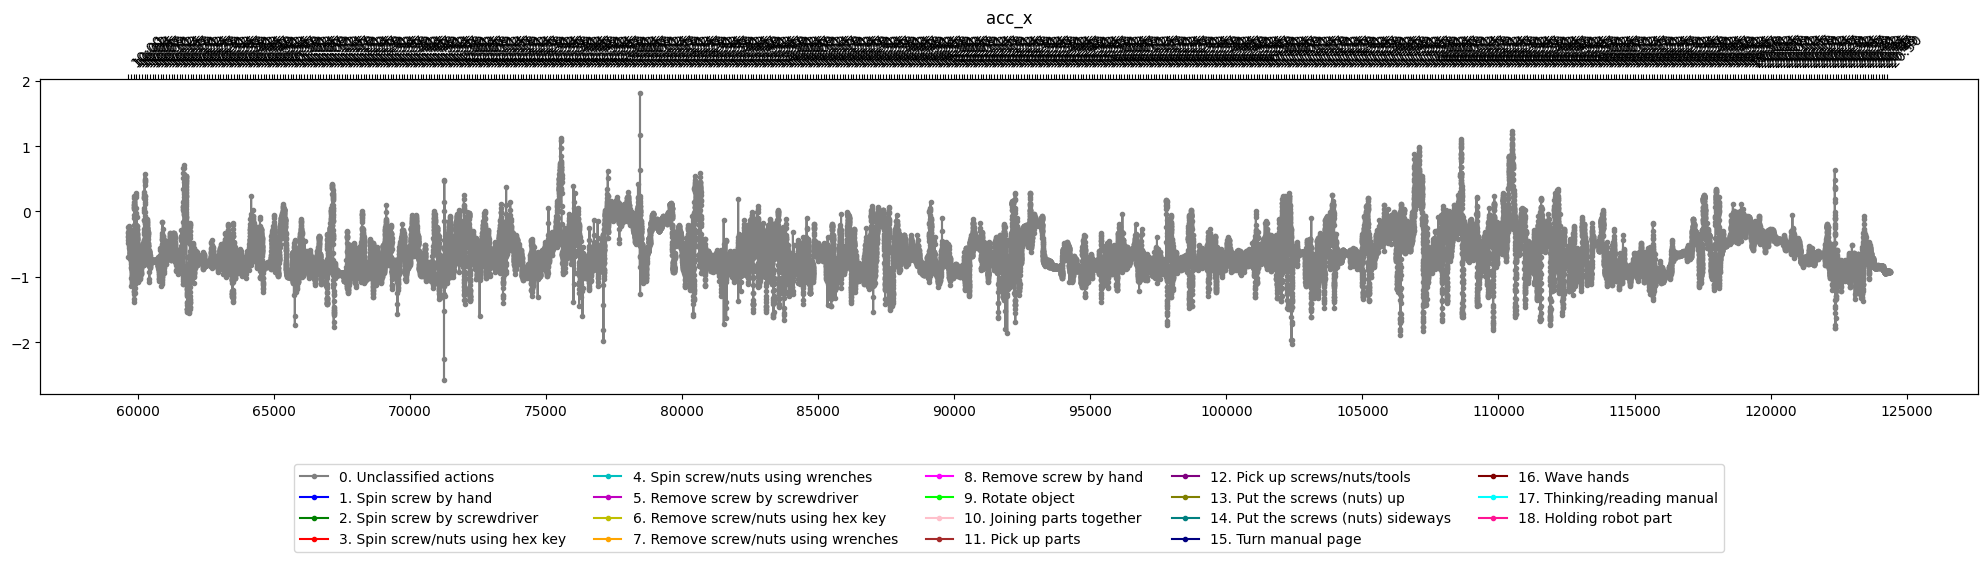

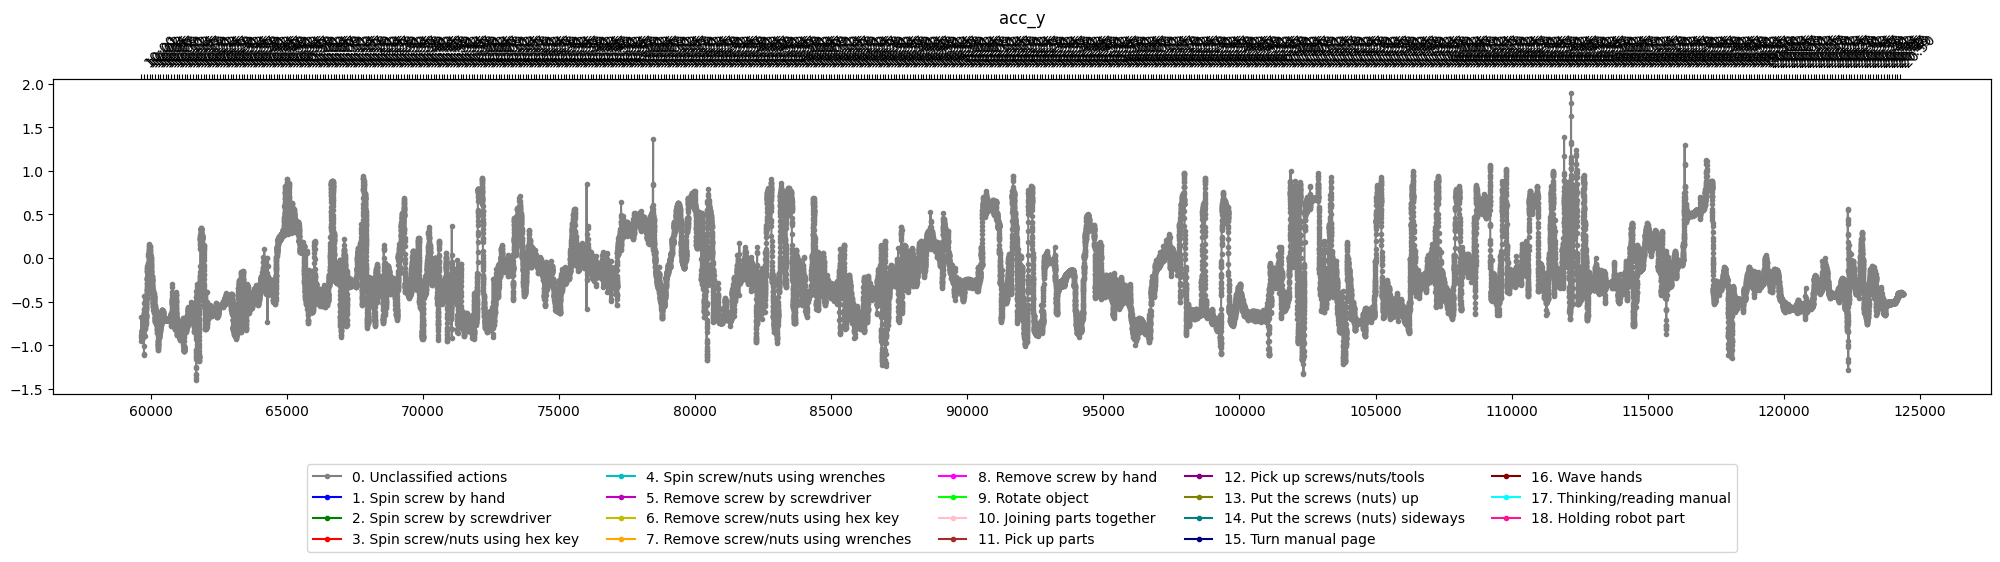

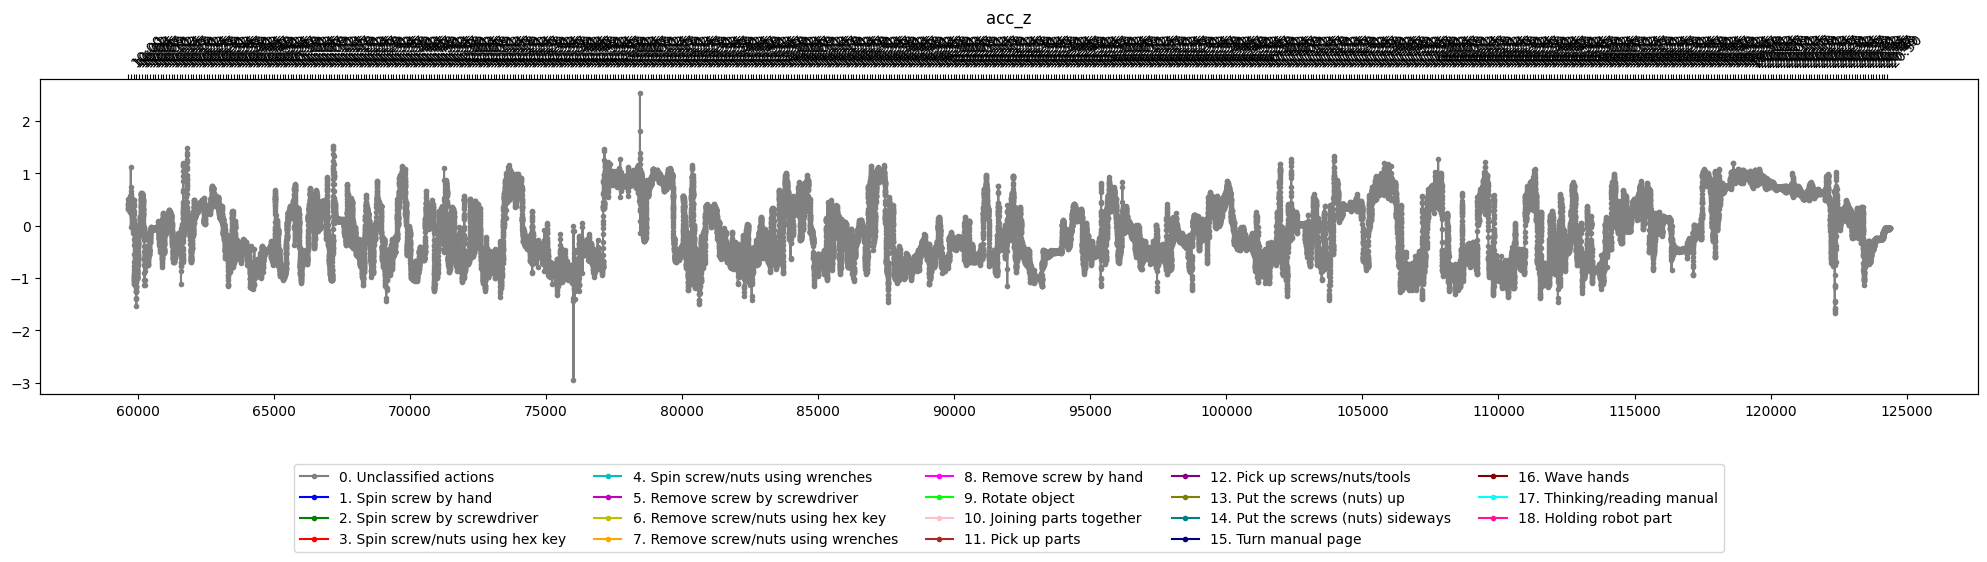

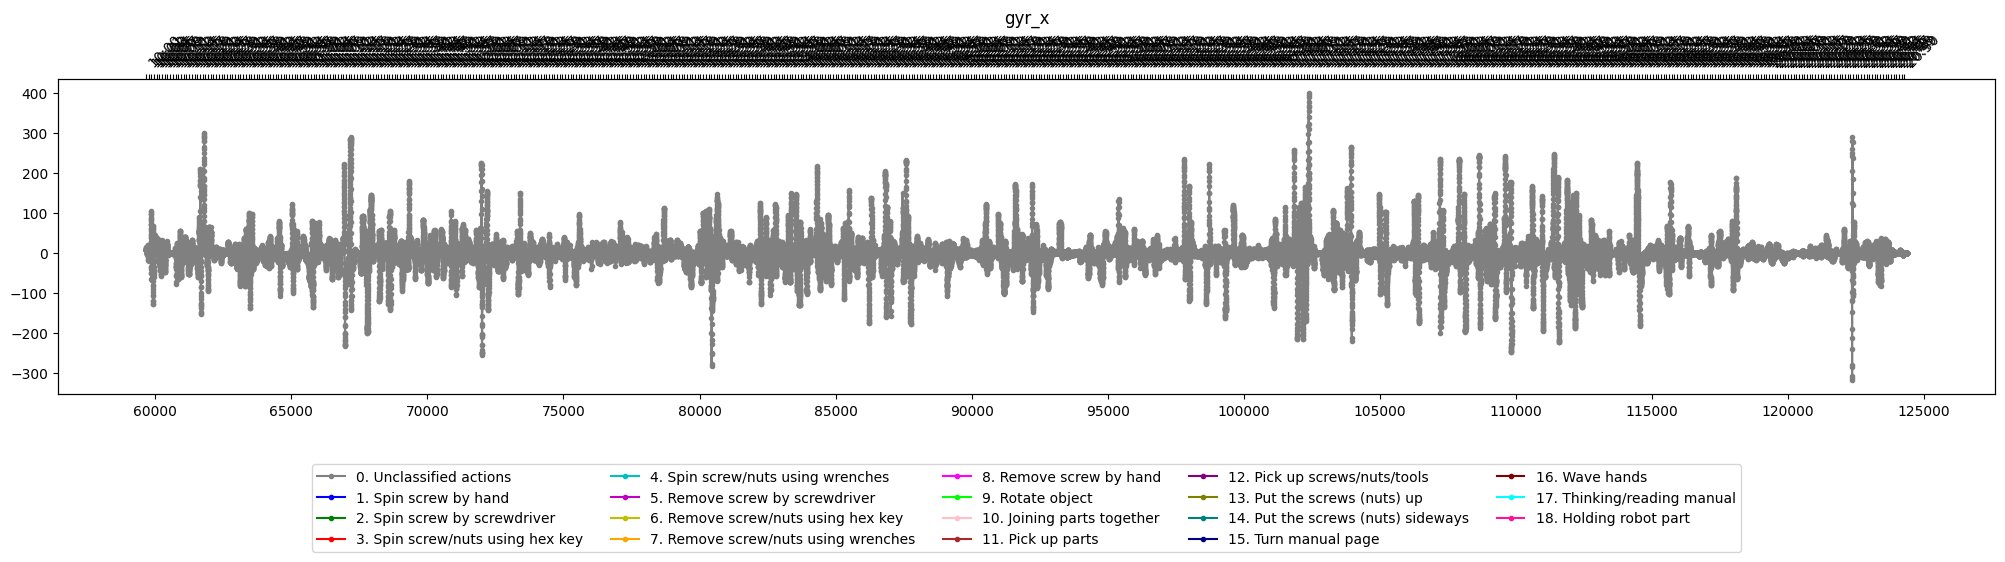

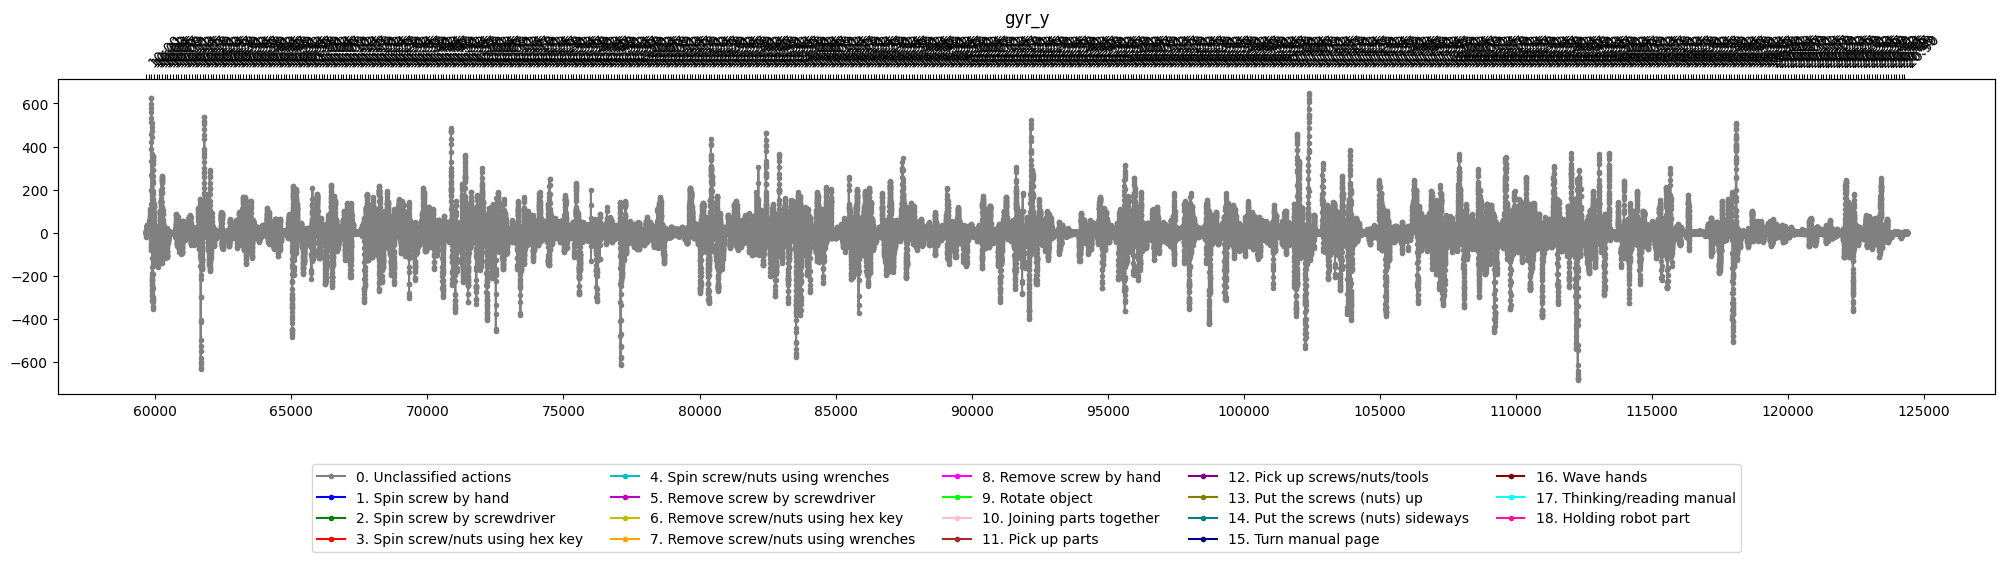

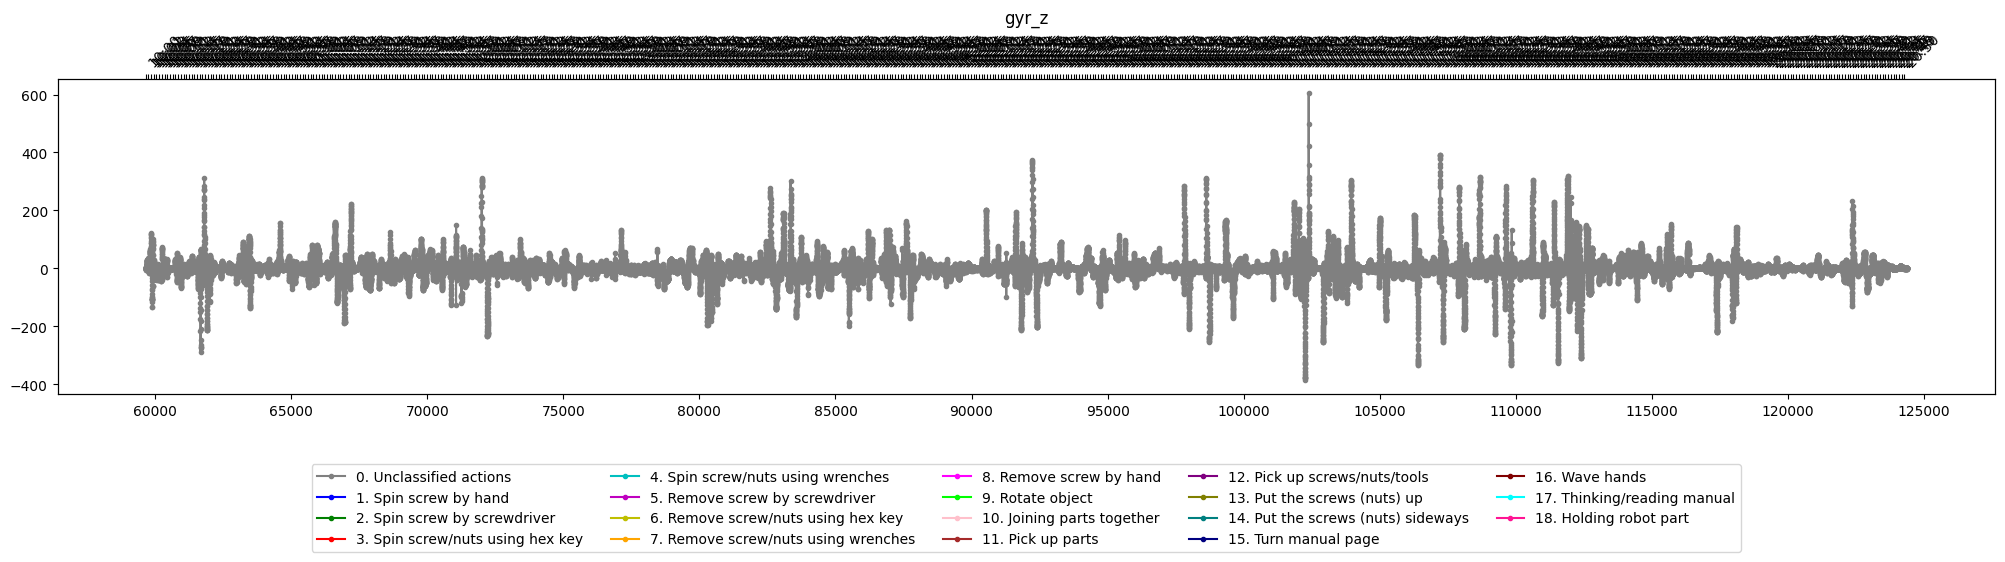

In [11]:
label_tool.plot_sig_by_videoTime_label('R', '10:00', '20:50')

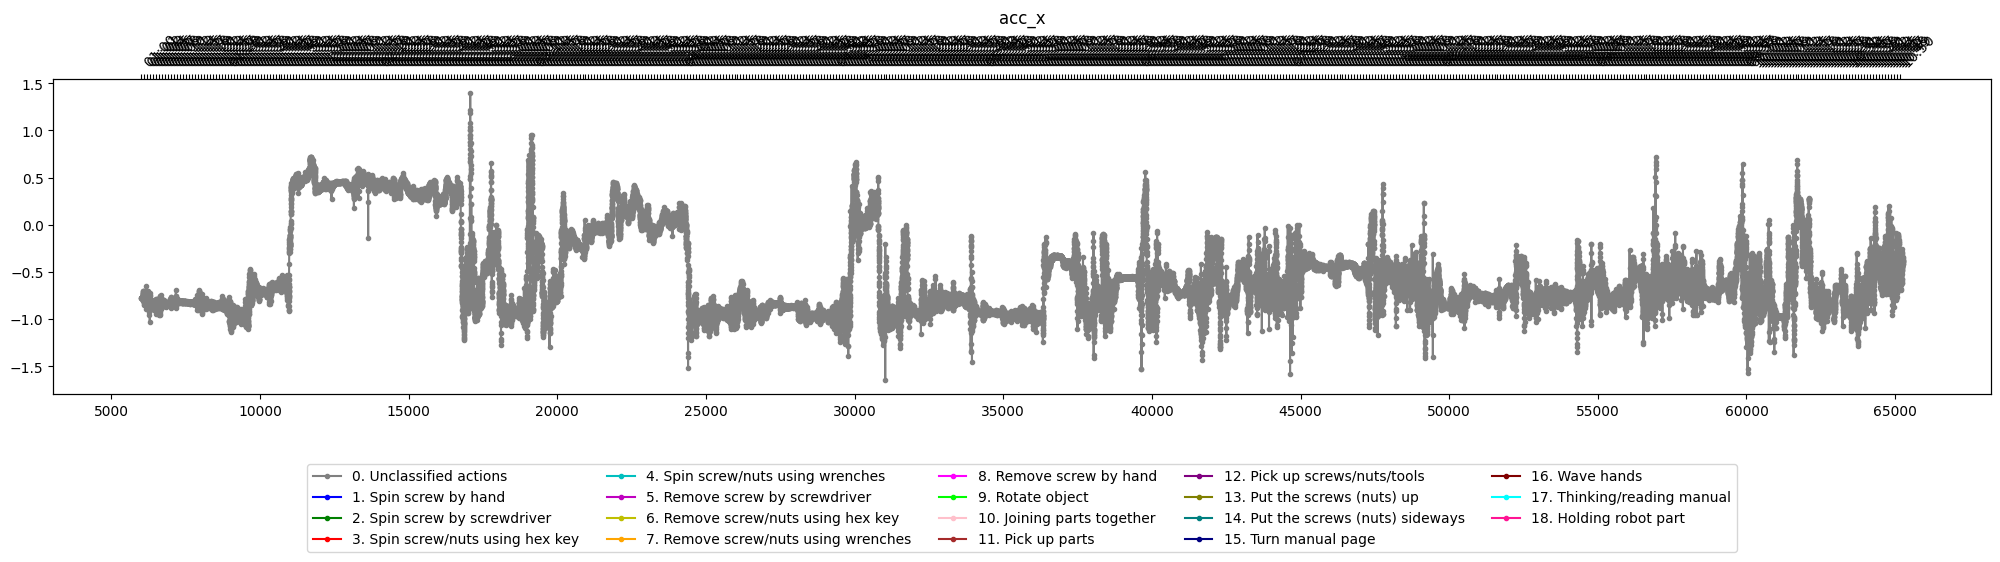

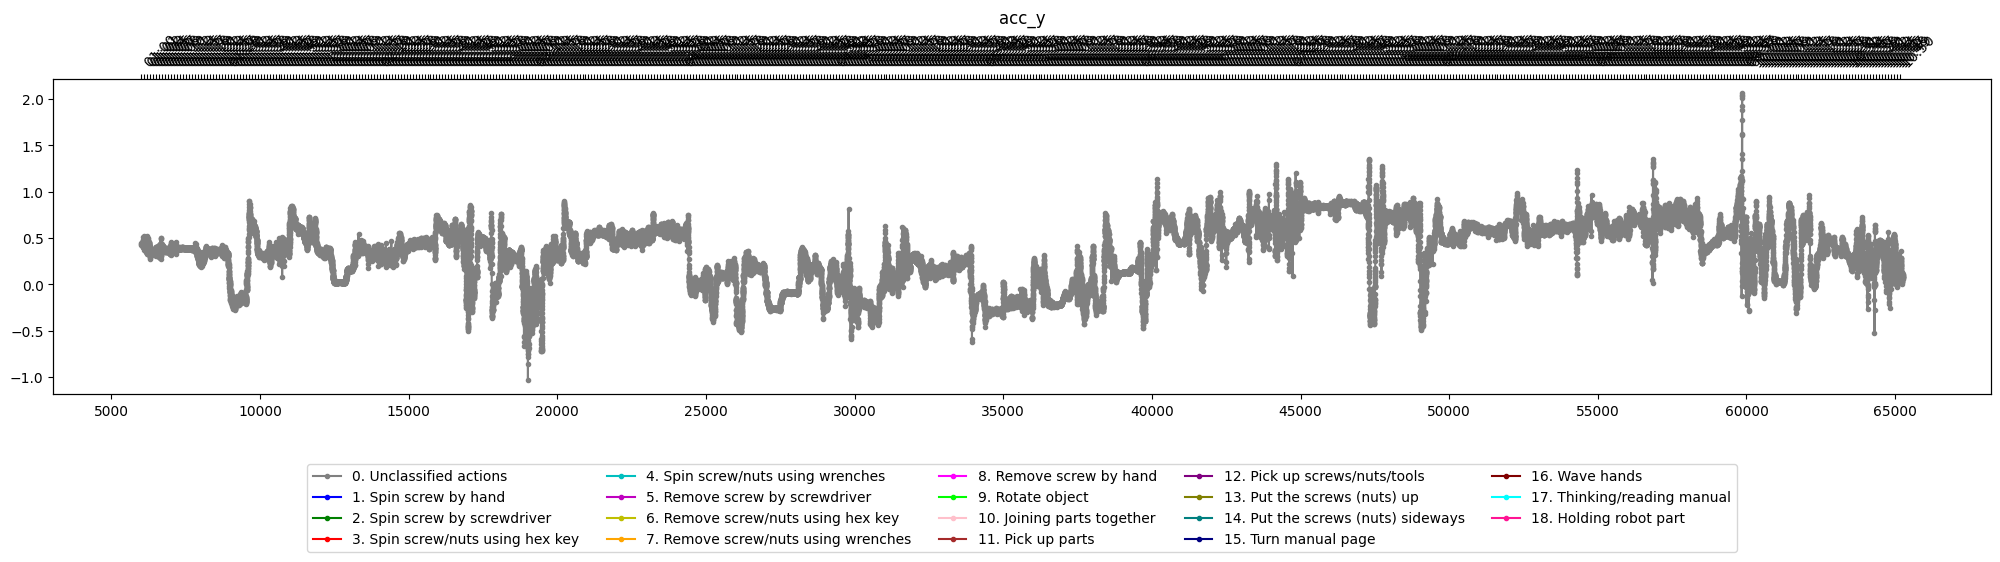

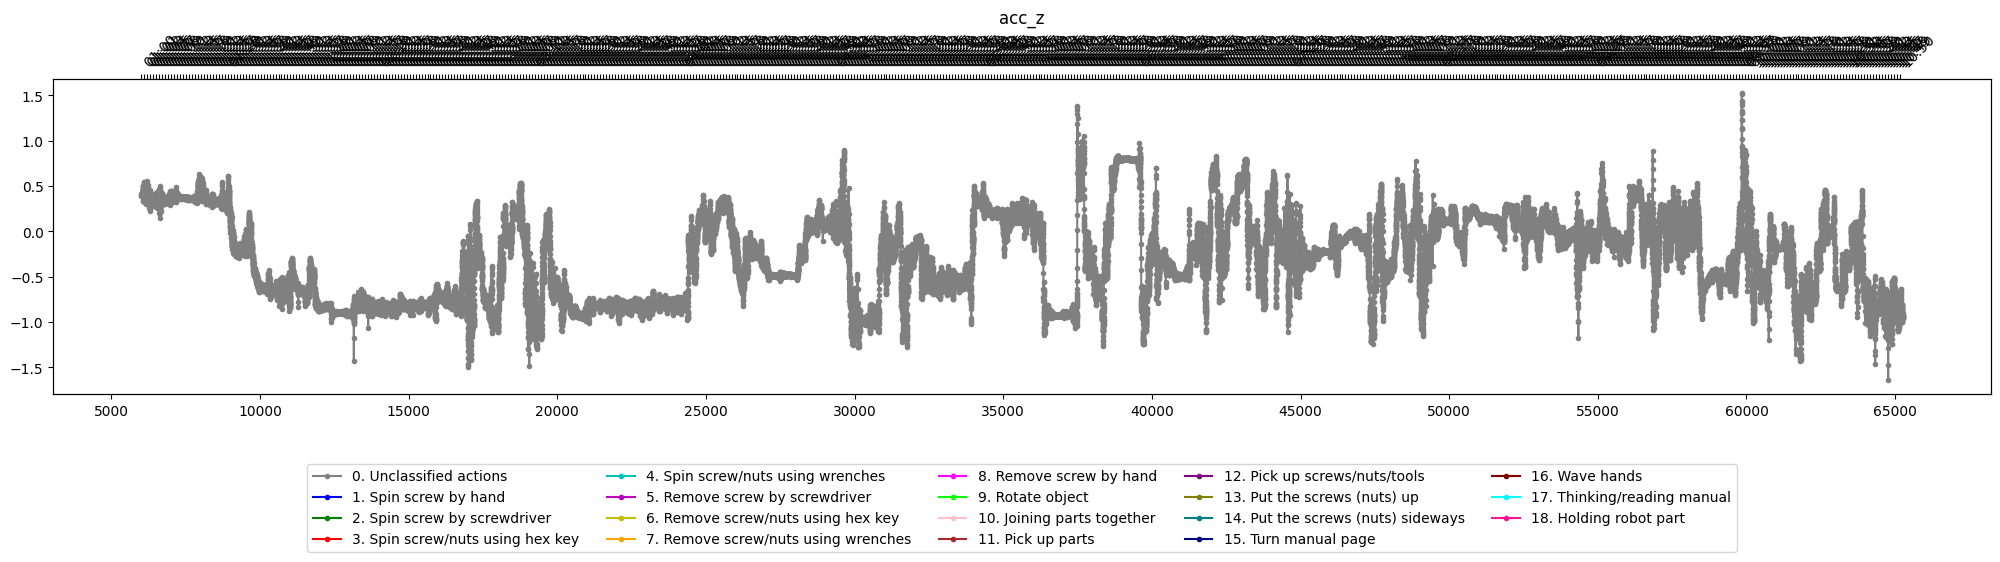

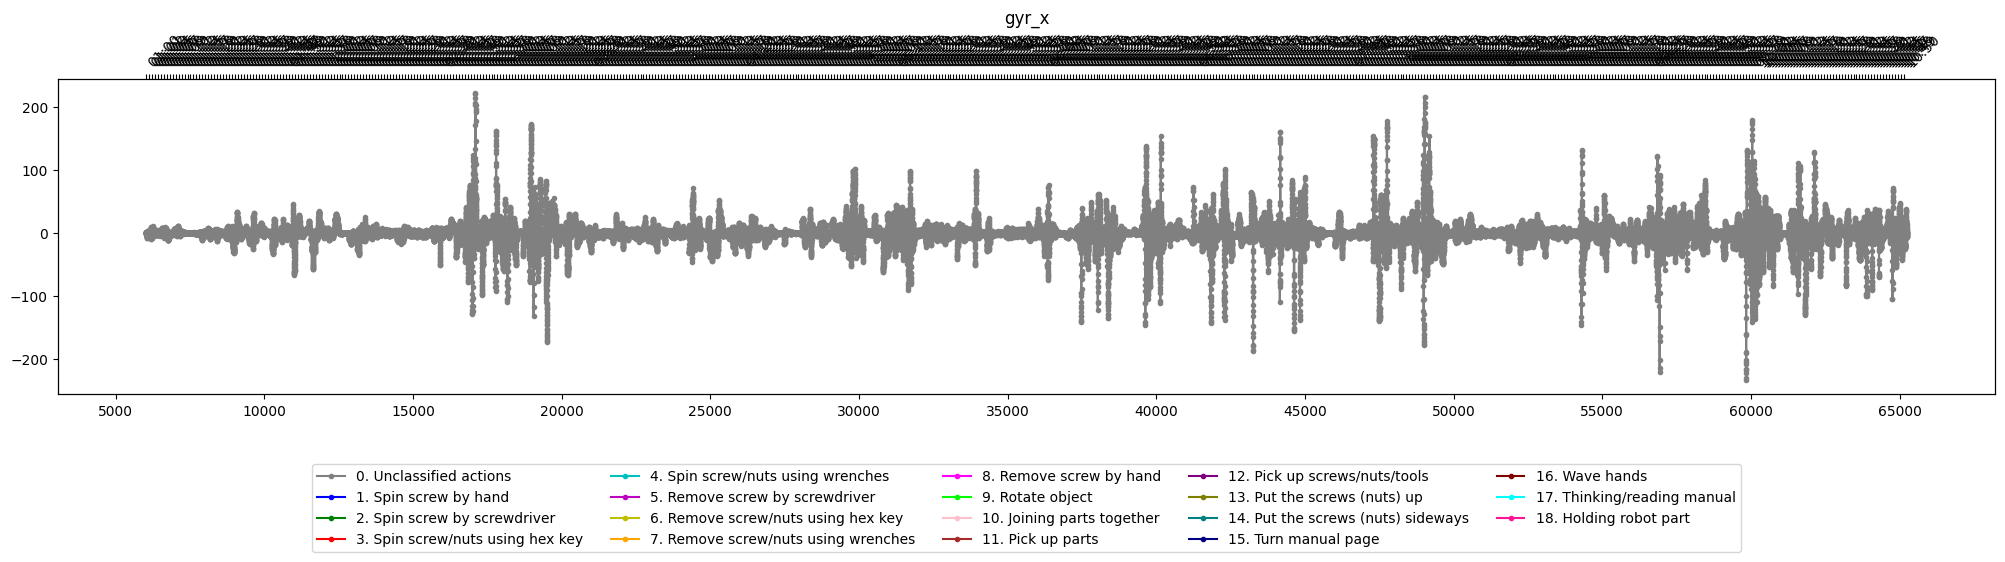

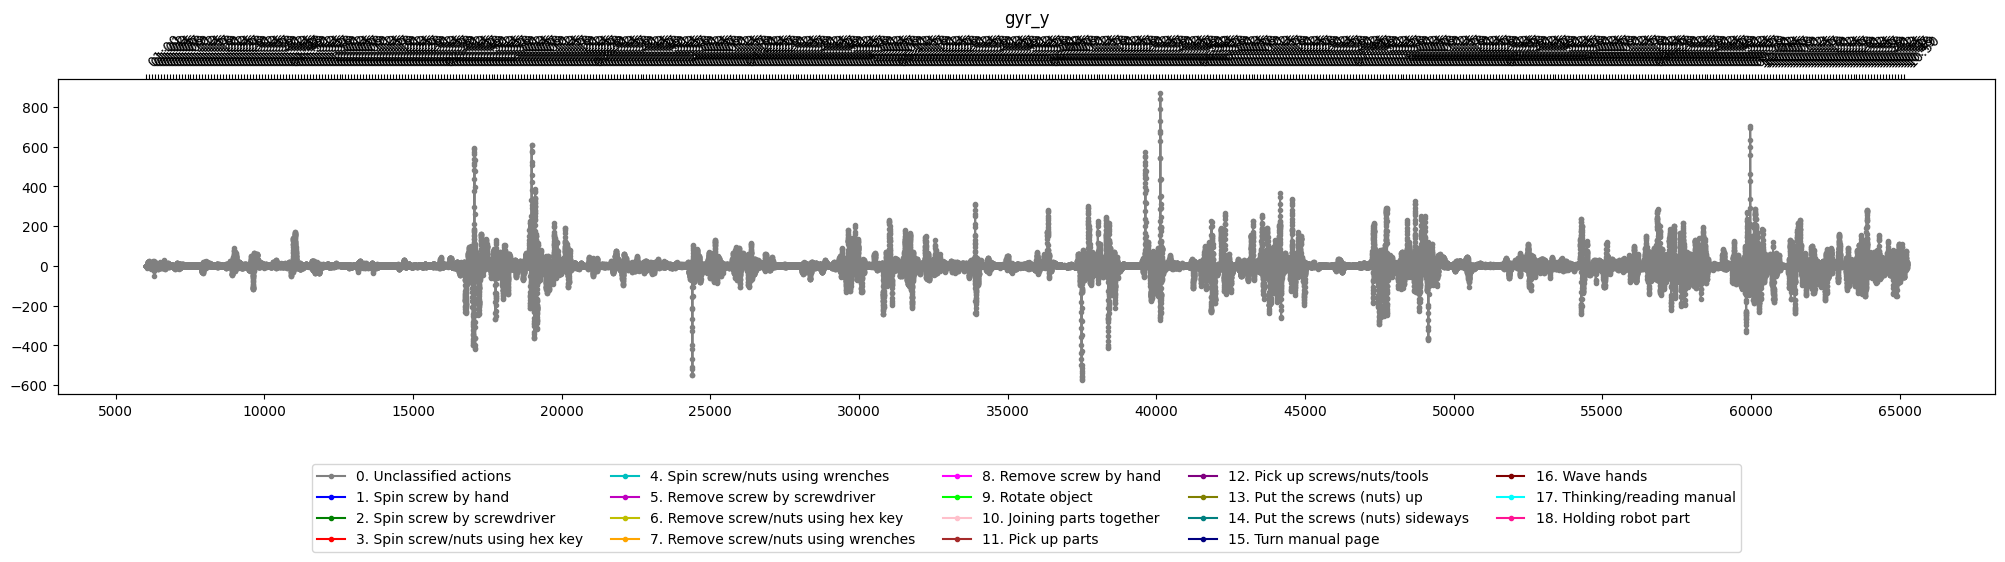

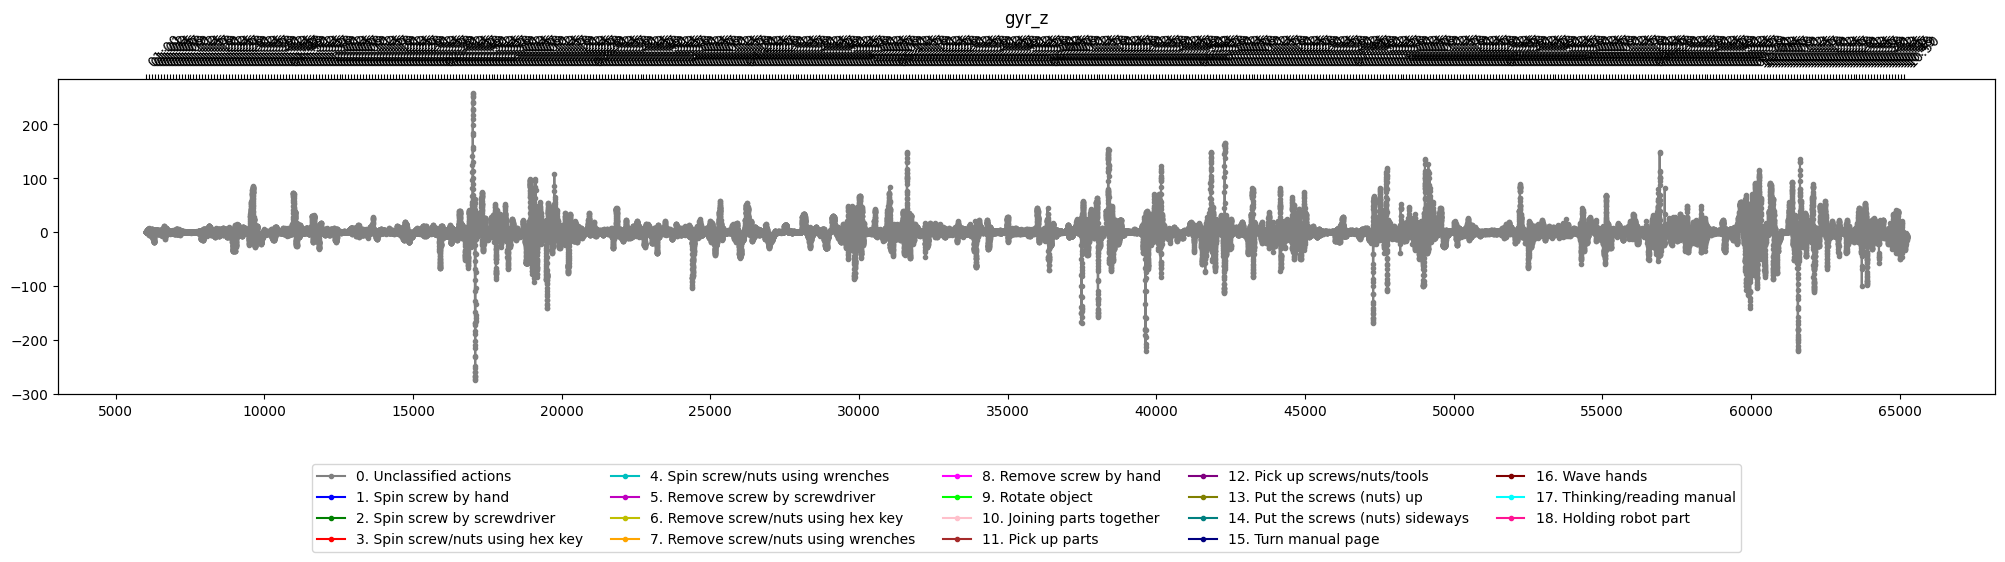

In [12]:
label_tool.plot_sig_by_videoTime_label('L', '01:00', '10:50')